### Install and import necessary packages

In [1]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 47.2 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a4076954e9fd632c8239f35581fc9c088b204efc55b2bc96f80a88726a056caa
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 9.5 MB/s 
     |██████████████████

In [2]:
import torch
import datasets
from collections import Counter
from datasets import load_dataset
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!ls '/content/drive/MyDrive/eth_CIL_exercise/data'
df_train = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/eth_CIL_exercise/data/clean_test.csv')
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


Mounted at /content/drive
clean_test.csv	clean_train.csv  clean_val.csv	logreg_input
(2000000, 2)
(500000, 2)
(10000, 2)


In [4]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'negative',
            1 : 'positive'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'negative', 1: 'positive'}


In [5]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)
train_ds[8] # Example of instance of the dataset

{'sentiment': 1,
 'tweet': 'recruiting senior sales manager for the spanish market ( based in dublin ) <url> please rt'}

## Tokenizing data - Model name

**model_name**
- [] model_name = 'xlnet-large-cased' | *seqlen= 512 ;  max_batch = 16*
- [x] model_name = 'xlnet-base-cased' | *seqlen= 64 ;  max_batch = 120*

In [6]:
# Load BERT/ROBERTA/XLNet tokenizer.
model_name = 'xlnet-base-cased' 
#model_name = 'xlnet-large-cased' 

In [7]:
tokenizer = XLNetTokenizer.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
#example: tokenizing one row
tokenizer(train_ds[7]['tweet'])

{'input_ids': [421, 469, 2812, 4035, 1986, 4240, 17, 167, 11140, 4240, 159, 17, 12, 1213, 1009, 710, 25315, 17, 98, 4969, 3893, 4240, 17, 10, 9084, 2765, 233, 52, 4240, 27, 17, 9, 9, 9, 7739, 1067, 368, 3151, 4, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['tweet'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=128) 
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['sentiment']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [10]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_val = encode_dataset(val_ds)
encoded_dataset_test = encode_dataset(test_ds)

In [11]:
# Example of dataset
for token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):
  print('{0:10}  {1}'.format(token, token_label))

<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad>       5
<pad> 

# Fine tunning of the model

In [12]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=128, #if use large model, batch = 16
    per_device_eval_batch_size=128, #if use large model, batch = 16
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/eth_CIL_exercise/',
    seed = 310,
    learning_rate = 5e-5
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
#model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=num_labels) 
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.transformer.mask_emb.requires_grad = False
model.transformer.word_embedding.weight.requires_grad = False
for name, param in model.transformer.layer.named_parameters():
  try:
    layer = int(name[:2])
  except ValueError:
    try:
      layer = int(name[:1])
    except ValueError:
      layer = 0
  if layer <= 20:
    param.requires_grad = False


# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Step,Training Loss
500,0.592400
1000,0.565800
1500,0.556800
2000,0.554500
2500,0.547400
3000,0.542500
3500,0.543000
4000,0.537500
4500,0.534300
5000,0.534700


Saving model checkpoint to drive/MyDrive/eth_CIL_exercise/checkpoint-500
Configuration saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/config.json
Model weights saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-500/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CIL_exercise/checkpoint-1000
Configuration saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CIL_exercise/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CIL_exercise/checkpoint-1500
Configuration saved in drive/MyDrive/eth_CI

TrainOutput(global_step=15625, training_loss=0.5339523911132813, metrics={'train_runtime': 11932.9794, 'train_samples_per_second': 167.603, 'train_steps_per_second': 1.309, 'total_flos': 1.42440139776e+17, 'train_loss': 0.5339523911132813, 'epoch': 1.0})

In [13]:
#print(model)

# Model evaluation

### Devset

In [14]:
# Get the predicted labels
preds_val = trainer.predict(encoded_dataset_val)
predictions = preds_val.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds_val.label_ids).flatten()
predicted_values = np.array(preds_val.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 500000
  Batch size = 128


In [15]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.760564
  f1-micro: 0.760564
  f1-macro: 0.7574417258756102



To understan better the performance of the classifier, we display the confusion matrix:

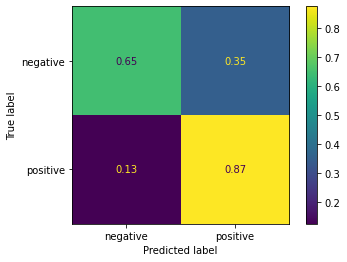

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

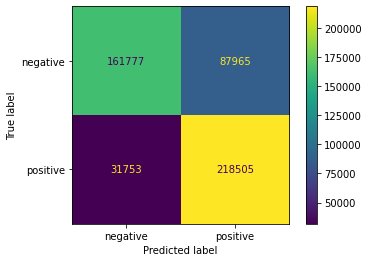

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()

exporting probability distribution prediction on devset resulting from trained model

In [18]:
preds_val #we need to retrieve the first elements of this dict

PredictionOutput(predictions=array([[ 0.31591648, -1.6624682 ],
       [-0.11530934, -0.7357981 ],
       [ 0.7113131 , -1.6058905 ],
       ...,
       [-1.3352715 ,  1.1090689 ],
       [-1.0458375 ,  0.51040524],
       [-0.2345552 , -0.9119745 ]], dtype=float32), label_ids=array([0, 0, 1, ..., 0, 1, 0]), metrics={'test_loss': 0.47220513224601746, 'test_runtime': 2818.1284, 'test_samples_per_second': 177.423, 'test_steps_per_second': 1.386})

In [19]:
pred_df = pd.DataFrame(preds_val[0]) #predicted_values  
pred_df.to_csv

<bound method NDFrame.to_csv of                0         1
0       0.315916 -1.662468
1      -0.115309 -0.735798
2       0.711313 -1.605891
3      -0.277818 -0.171391
4      -0.635772 -0.349426
...          ...       ...
499995  2.704265 -2.843939
499996  0.317198 -0.481606
499997 -1.335271  1.109069
499998 -1.045838  0.510405
499999 -0.234555 -0.911974

[500000 rows x 2 columns]>

In [20]:
pred_df.head(2)

,0,1
0,0.315916,-1.662468
1,-0.115309,-0.735798


In [21]:
from google.colab import files
pred_df.to_csv('pred_val_1.csv',index=False,header=False,sep=',')
files.download('pred_val_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
pred_df.shape

(500000, 2)

### Testset - PREDICTION

In [32]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)

# Create array with predicted labels and expected.
#TODELETE: true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

***** Running Prediction *****
  Num examples = 10000
  Batch size = 128


In [33]:
pred_dft = pd.DataFrame(preds[0]) #predicted_values  
from google.colab import files
pred_dft.to_csv('pred_test-prob_1.csv',index=False,header=False,sep=',')
files.download('pred_test-prob_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
pred_test = pd.DataFrame({'Prediction': predicted_values})
pred_test = pd.DataFrame({'Id': pred_test.index + 1 ,'Prediction': predicted_values}) #add columns Id as sample_submission file
pred_test.loc[pred_test['Prediction'] < 1, 'Prediction'] = -1 #replace 0 by -1

In [35]:
from google.colab import files
pred_test.to_csv('pred_test_1.csv',index=False)
files.download('pred_test_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>